In [16]:
from copy import deepcopy
from itertools import cycle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Probabilities
Below is a way to set a decaying curve of probabilities that sum to 100%. This probabilities can be set to whatever.

### Extra Rarity Tier
I added a 6th tier for whole and special attributes that has low rarity. This was to keep the sum equal 1.

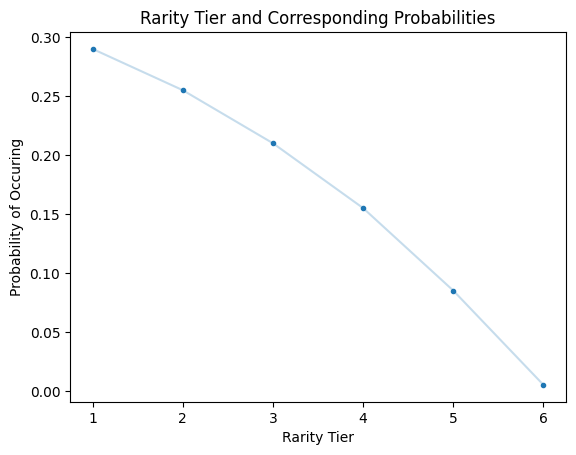

In [17]:
decay = .01
# as decay approaches 0, function becomes linear
# as decay approaches 100, function becomes constant (equal probabiltiies)
# decay between (.01, .1) is shades of exponential decay

probs = 1 - np.exp(-decay * np.linspace(100, 1.1, 6))
probs /= probs.sum() # normalize s.t. the sum is 1
probs = probs.round(3).astype(np.float32)

# Rounded to nearest 5
probs = np.array([290, 255, 210, 155, 85, 5], dtype=np.float32)
probs /= 1000

tiers = np.arange(1, 7)

plt.title('Rarity Tier and Corresponding Probabilities')
plt.plot(tiers, probs, alpha=.25)
plt.plot(tiers, probs, ls='', marker='.', color='C0')
plt.ylabel('Probability of Occuring')
plt.xticks(ticks=tiers)
plt.xlabel('Rarity Tier');

In [18]:
print('Tiers  :', tiers)
print('Probs  :', probs)
print('Total  :', (probs * 1000).astype(int))

Tiers  : [1 2 3 4 5 6]
Probs  : [0.29  0.255 0.21  0.155 0.085 0.005]
Total  : [290 255 210 155  85   5]


### Generating Assets
For each asset, e.g. heads, there are N heads per rarity tier. The table below was pulled from the spreadsheet:
```
Tier  N_Heads
----  -------
1     9
2     9
3     16
4     24
5     3
```
For 1000 samples & tier 1 heads, there should be 362 heads that ~evenly consists of the 9 tier 1 head variations. This is 40/41 heads per tier 1 head type (this number would change based on the number of tier 1 heads). At the bottom of the page is the number of heads generate for each of the tier 1 types.

The same procedure can be applied to all body part / asset types.

In [19]:
class AssetPool:
    """Pool of all attributes."""
    def __init__(self):
        self.pool = {}
        for k in ['Head', 'Upper Body', 'Right Arm', 'Left Arm', 'Legs',
                  'Feet', 'Companion', 'Walk Effect', 'Outerwear',
                  'Accessories', 'Special', 'Whole']:
            self.pool[k] = []
            
        self.dfs = []
    
    def add_asset(self, asset, asset_type):
        self.pool[asset_type].append(asset)
        
    def add_df(self, df):
        self.dfs.append(df)
        
    
class Asset:
    """Single Attribute."""
    def __init__(self, asset):
        self.asset = asset
        
        self.rules = []
        self.rule_logic = []
        self.rule_attribute = []
        
        self.frozen = False
        self.callback = None
        
    def add_rule(self, rule):
        self.rules.append(rule)
        
    def parse_rules(self):
        if len(self.rules) != 0:
            for rule in self.rules:
                logic = rule.split(' ')[0]
                attribute = rule.replace(logic + ' ', '')
                self.rule_logic.append(logic)
                self.rule_attribute.append(attribute)

In [20]:
rulebook = pd.read_csv('./rulebook.csv')

# Total number of generations
n = 1000
n_per_1000 = (probs * n).astype(int)

asset_pool = AssetPool()

for asset_type in rulebook['Type'].unique():
    
    rows = np.where(rulebook['Type'] == asset_type)[0]
    assets = rulebook.iloc[rows].copy()
    
    # Weights with 'rand' are randomly set between 1-5
    #   this should be removed when rulebook is updated
    rng = np.where(assets['Rarity Tier'] == 'rand')[0]
    if len(rng) > 0:
        _weights = assets['Rarity Tier'].copy()
        _weights.iloc[rng] = np.random.choice(np.arange(1, 6), len(rng))
        assets['Rarity Tier'] = _weights
        
    # Get rarity tier of each asset
    weights = assets['Rarity Tier'].astype(int).values
      
    # Get number of times an asset should occur
    occurances = np.zeros(len(assets), dtype=int)
    
    for tier, j in zip(tiers, n_per_1000):

        inds = np.where(weights == tier)[0]

        if len(inds) == 0:
            continue

        inds_cyc = cycle(inds)

        for _ in range(j):
            occurances[next(inds_cyc)] += 1
    
    assets['Occurances'] = occurances
    
    # For each asset and number of expected occurances
    #   Create a pool of assets to later sample from
    for ia in range(len(assets)):
        for io in range(assets.iloc[ia]['Occurances']):
            
            # Add rarity percentage
            assets['Rarity'] = [probs[i-1] for i in assets['Rarity Tier'].astype(int)]
            
            # Rules
            rule_group = assets.iloc[ia]['Group Rules']
            rule_individual = assets.iloc[ia]['Individual Rules']
            
            asset = Asset(assets.iloc[ia])
            
            if isinstance(rule_group, str):
                asset.add_rule(rule_group)
            if isinstance(rule_individual, str):
                rule_individual = rule_individual.split(';')
                if len(rule_individual) == 1:
                    asset.add_rule(rule_individual[0])
                else:
                    for r in rule_individual:
                        asset.add_rule(r)
            
            if len(asset.rules) != 0:
                asset.parse_rules()
                
            asset_pool.add_asset(asset, assets.iloc[ia]['Type'])

In [21]:
# inds_head = np.arange(len(asset_pool.pool['Head']))
# inds_upper_body = np.arange(len(asset_pool.pool['Upper Body']))
# inds_right_arm = np.arange(len(asset_pool.pool['Right Arm']))
# inds_left_arm = np.arange(len(asset_pool.pool['Left Arm']))
# inds_legs = np.arange(len(asset_pool.pool['Legs']))
# inds_feet = np.arange(len(asset_pool.pool['Feet']))
# inds_companion = np.arange(len(asset_pool.pool['Companion']))
# inds_walk_effect = np.arange(len(asset_pool.pool['Walk Effect']))


# np.random.seed(0)
# np.random.shuffle(inds_head)

# np.random.seed(1)
# np.random.shuffle(inds_upper_body)

# np.random.seed(2)
# np.random.shuffle(inds_right_arm)

# np.random.seed(3)
# np.random.shuffle(inds_left_arm)

# np.random.seed(4)
# np.random.shuffle(inds_feet)

# np.random.seed(5)
# np.random.shuffle(inds_companion)

# np.random.seed(6)
# np.random.shuffle(inds_walk_effect)

In [22]:
for part in ['Upper Body', 'Right Arm', 'Left Arm', 'Legs']:
    
    for ind, asset in enumerate(asset_pool.pool[part]):

        if len(asset.rule_logic) != 0:

            # Callbacks
            if asset.rule_logic[0] == 'Call':
                asset.callback = asset.rule_attribute[0]
                continue # handled later
            if asset.rule_logic[0] == 'Allow':
                continue # handled later

            body_part, col, val = asset.rule_attribute[0].split(':')
            
            if "Arm" in body_part:
                if "Right" in body_part:
                    body_part = "Right Arm"
                else:
                    body_part = "Left Arm"     
            if "Body" in body_part:
                body_part = "Upper Body"
            
            if val == 'Any':
                continue # handled later
                
            # Apply rules
            if asset.rule_logic[0] == 'Except':
                # Match anything except rule (e.g. cross-body right arms)
                if asset_pool.pool[body_part][ind].asset[col] == val:
                    
                    
                    select = np.where(
                        (np.array([i.asset[col] for i in asset_pool.pool[body_part]]) != val) &
                        (~np.array([i.frozen for i in asset_pool.pool[body_part]]))
                    )[0]

                    select = np.random.choice(select)

                    old = deepcopy(asset_pool.pool[body_part][ind])
                    new = deepcopy(asset_pool.pool[body_part][select])
                    asset_pool.pool[body_part][ind] = new
                    asset_pool.pool[body_part][select] = old

                # Freeze attributes
                asset.frozen = True

            if asset.rule_logic[0] == 'Match':
                # Match rule (e.g. overall body with overall legs)
                select = np.where(
                    (np.array([i.asset[col] for i in asset_pool.pool[body_part]]) == val) &
                    (~np.array([i.frozen for i in asset_pool.pool[body_part]]))
                )[0]

                if len(select) == 0:
                    # Already matched
                    continue

                select = np.random.choice(select)

                old = deepcopy(asset_pool.pool[body_part][ind])
                new = deepcopy(asset_pool.pool[body_part][select])
                asset_pool.pool[body_part][ind] = new
                asset_pool.pool[body_part][select] = old

                asset_pool.pool[body_part][ind] = new
                asset_pool.pool[body_part][select] = old

                asset_pool.pool[body_part][ind].frozen = True
                asset.frozen = True

In [23]:
attrs = ['Head', 'Upper Body', 'Right Arm', 'Left Arm', 'Legs', 'Feet', 'Walk Effect']

for ai, attr in enumerate(attrs):
    np.random.seed(ai)
    _assets = asset_pool.pool[attr]
    inds = np.arange(len(_assets))
    np.random.shuffle(inds)
    assets_shuffle = [_assets[i] for i in inds]
    asset_pool.pool[attr] = assets_shuffle

Note: Tere are 995 per head (etc) because each of the whole sets occur once.

In [24]:
for k in asset_pool.pool.keys():
    print(k, len(asset_pool.pool[k]))

Head 995
Upper Body 995
Right Arm 995
Left Arm 995
Legs 995
Feet 995
Companion 365
Walk Effect 995
Outerwear 155
Accessories 620
Special 85
Whole 5


In [25]:
# Every generation will have these attributes
attrs = ['Head', 'Upper Body', 'Right Arm', 'Left Arm', 'Legs', 'Feet', 'Walk Effect']
nomads = []

for i in range(995):
    nomad = {}
    for attr in attrs:
        nomad[asset_pool.pool[attr][i].asset['Type']] = \
              asset_pool.pool[attr][i].asset['Asset']
        nomad[asset_pool.pool[attr][i].asset['Type'] + ' Rarity Tier'] = \
            str(asset_pool.pool[attr][i].asset['Rarity Tier'])
        nomad[asset_pool.pool[attr][i].asset['Type'] + ' Rarity'] = \
            str(asset_pool.pool[attr][i].asset['Rarity'])
    nomads.append(nomad)
    
# Companions:
inds = np.array([ind for ind, i in enumerate(nomads) if i['Right Arm'] != 'ETH Bag'])

n_companions = len(asset_pool.pool['Companion'])
np.random.seed(0)
inds = np.random.choice(inds, n_companions, replace=False)

i_companion = 0
for i in range(995):
    if i in inds:
        nomads[i]['Companion'] = asset_pool.pool['Companion'][i_companion].asset['Asset']
        nomads[i]['Companion' + ' Rarity Tier'] = asset_pool.pool['Companion'][i_companion].asset['Rarity Tier']
        nomads[i]['Companion' + ' Rarity'] = str(asset_pool.pool['Companion'][i_companion].asset['Rarity'])
        i_companion += 1
    else:
        nomads[i]['Companion'] = 'None'
        
# Outerwear
inds = np.arange(995)

n_companions = len(asset_pool.pool['Companion'])
np.random.seed(1)
inds = np.random.choice(inds, n_companions, replace=False)

i_outerwear = 0
for i in range(995):
    if i in inds:
        nomads[i]['Outerwear'] = asset_pool.pool['Outerwear'][i_outerwear].asset['Asset']
        nomads[i]['Outerwear' + ' Rarity Tier'] = asset_pool.pool['Outerwear'][i_outerwear].asset['Rarity Tier']
        nomads[i]['Outerwear' + ' Rarity'] = str(asset_pool.pool['Outerwear'][i_outerwear].asset['Rarity'])
        i_companion += 1
    else:
        nomads[i]['Outerwear'] = 'None'

# Accessories: Skiping for now, not in AE comp
inds = np.arange(995)

n_accessories =  len(asset_pool.pool['Accessories'])

inds = np.random.choice(inds, n_accessories, replace=False)

i_accessory = 0

for i in range(995):
    if i in inds:
        nomads[i]['Accessory'] = asset_pool.pool['Accessories'][i_accessory].asset['Asset']
        nomads[i]['Accessory' + ' Rarity Tier'] = asset_pool.pool['Accessories'][i_accessory].asset['Rarity Tier']
        nomads[i]['Accessory' + ' Rarity'] = str(asset_pool.pool['Accessories'][i_accessory].asset['Rarity'])
        i_accessory += 1
    else:
        nomads[i]['Accessory'] = None

# Whole
for i in asset_pool.pool['Whole']:
    nomads.append({
        'Whole': i.asset['Asset'],
        'Whole Rarity Tier': 6,
        'Whole Rarity': '0.001'
    })

In [26]:
backgrounds = ['Blue', 'Green', 'Orange', 'Purple', 'Red']
backgrounds = cycle(backgrounds)

In [27]:
import json

for i in range(len(nomads)):
    
    nomads[i]['Background'] = next(backgrounds)
        
    with open(f'json/Nomad#{str(i).zfill(3)}.json', 'w') as f:
        json.dump(nomads[i], f, indent='\t')

In [28]:
nomads[0]

{'Head': 'Eye of Truth',
 'Head Rarity Tier': '3',
 'Head Rarity': '0.21',
 'Upper Body': 'Diamond Rune',
 'Upper Body Rarity Tier': '2',
 'Upper Body Rarity': '0.255',
 'Right Arm': 'Bone Axe',
 'Right Arm Rarity Tier': '4',
 'Right Arm Rarity': '0.155',
 'Left Arm': 'Neutral Left Arm',
 'Left Arm Rarity Tier': '5',
 'Left Arm Rarity': '0.085',
 'Legs': 'Jorts',
 'Legs Rarity Tier': '2',
 'Legs Rarity': '0.255',
 'Feet': 'Space Boots',
 'Feet Rarity Tier': '4',
 'Feet Rarity': '0.155',
 'Walk Effect': 'Balls of Soot',
 'Walk Effect Rarity Tier': '3',
 'Walk Effect Rarity': '0.21',
 'Companion': 'None',
 'Outerwear': 'Dark Wanderer Hood',
 'Outerwear Rarity Tier': '4',
 'Outerwear Rarity': '0.155',
 'Accessory': 'Air Tank',
 'Accessory Rarity Tier': '3',
 'Accessory Rarity': '0.21',
 'Background': 'Blue'}

### Stats
The stats below will hold for:

```
Head
Upper Body
Right Arm
Left Arm
Legs
Feet
Walk Effect
```

Note that:

- Accessories ranges from tier 2-4 (620 out of 1000)
- Companions range from tier 3-4 (365 of out 1000)
- Outerwear is more rare at tier 4 (155 out of 1000)
- Whole sets are the rarest at special tier 6 (1 out 1000 per whole set)

In [29]:
rarity_tiers_generated = np.array([int(i['Head Rarity Tier']) for i in nomads[:-5]])

df_stats = pd.DataFrame()

n_per = []
for i in range(1, 6):
    n_per.append(np.count_nonzero(rarity_tiers_generated == i))
n_per = np.array(n_per)

df_stats['tiers'] = tiers[:-1]
df_stats['n_per_tier'] = n_per
df_stats['% per tier'] = (n_per / 1000) * 100
df_stats

,tiers,n_per_tier,% per tier
0,1,290,29.0
1,2,255,25.5
2,3,210,21.0
3,4,155,15.5
4,5,85,8.5
